In [88]:
import pickle
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from graphviz import Digraph
import pygraphviz
%matplotlib inline

In [89]:
# initialize graph
G = nx.DiGraph()

circuit_path = "../simple_circuit.pkl"
circuit_figure_filename = os.path.basename(circuit_path).split(".pkl")[0] + ".png"
circuit_figure_path = os.path.join("../figures/circuits", circuit_figure_filename)

# load dictionary
with open(circuit_path, "rb") as circuit_pickle:
    circuit = pickle.load(circuit_pickle)

In [5]:
G.graph['node'] = {'shape': 'box', 'style': 'rounded'}
G.graph['graph'] = {'rankdir': 'BT'}
textcolor = "black"     # easy to change in case we use colors where white text will look better

for parent in circuit:
    if parent not in G.nodes:
        if "mlp" in parent:
            nodecolor = "#e5ad76"   # camel
        elif "attn" in parent:
            nodecolor = "#5baf7e"   # kelly green
        elif "resid" in parent:
            nodecolor = "#88a7cd"   # pastel steel blue
        else:
            nodecolor = "white"

        if parent != "y":
            layer, feat_idx, component = parent.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            rank = int(layer) + 2
        else:
            nodename = "y"
            rank = 1
        G.add_node(parent, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
                   rank=rank)
    for child in circuit[parent]:
        child_name, child_effect = child
        if child_name not in G.nodes:
            if "mlp" in child_name:
                nodecolor = "#e5ad76"
            elif "attn" in child_name:
                nodecolor = "#5baf7e"
            elif "resid" in child_name:
                nodecolor = "#88a7cd"
            else:
                nodecolor = "white"
            
            layer, feat_idx, component = child_name.split("_")
            rank = int(layer) + 2
            nodename = f"{component}_{layer}/{feat_idx}"
            G.add_node(child_name, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
                       rank=rank)
        G.add_edge(child_name, parent)

A = to_agraph(G)
A.layout('dot')
print(A)

# if not os.path.exists("../figures/circuits/"):
#     os.makedirs("../figures/circuits/")
# A.draw(circuit_figure_path)

strict digraph "" {
	graph [bb="0,0,1614.5,180",
		rankdir=BT
	];
	node [label="\N",
		shape=box,
		style=rounded
	];
	y	[fillcolor=white,
		fontcolor=black,
		height=0.5,
		label=y,
		pos="685.5,162",
		rank=1,
		style="rounded,filled",
		width=0.75];
	"5_7352_mlp"	[fillcolor="#e5ad76",
		fontcolor=black,
		height=0.5,
		label="mlp_5/7352",
		pos="41.5,90",
		rank=7,
		style="rounded,filled",
		width=1.1528];
	"5_7352_mlp" -> y	[pos="e,658.22,160.87 83.034,105.95 85.879,106.72 88.719,107.41 91.5,108 298.52,151.77 553.58,159.43 648.03,160.74"];
	"5_21277_mlp"	[fillcolor="#e5ad76",
		fontcolor=black,
		height=0.5,
		label="mlp_5/21277",
		pos="145.5,90",
		rank=7,
		style="rounded,filled",
		width=1.2361];
	"5_21277_mlp" -> y	[pos="e,658.34,159.91 190.11,105.79 193.27,106.6 196.42,107.35 199.5,108 364.63,142.64 566.35,155.44 648.27,159.43"];
	"5_31457_resid"	[fillcolor="#88a7cd",
		fontcolor=black,
		height=0.5,
		label="resid_5/31457",
		pos="255.5,90",
		rank=7,
		style="rounded,fille

# WIP: Depth by Layer Index

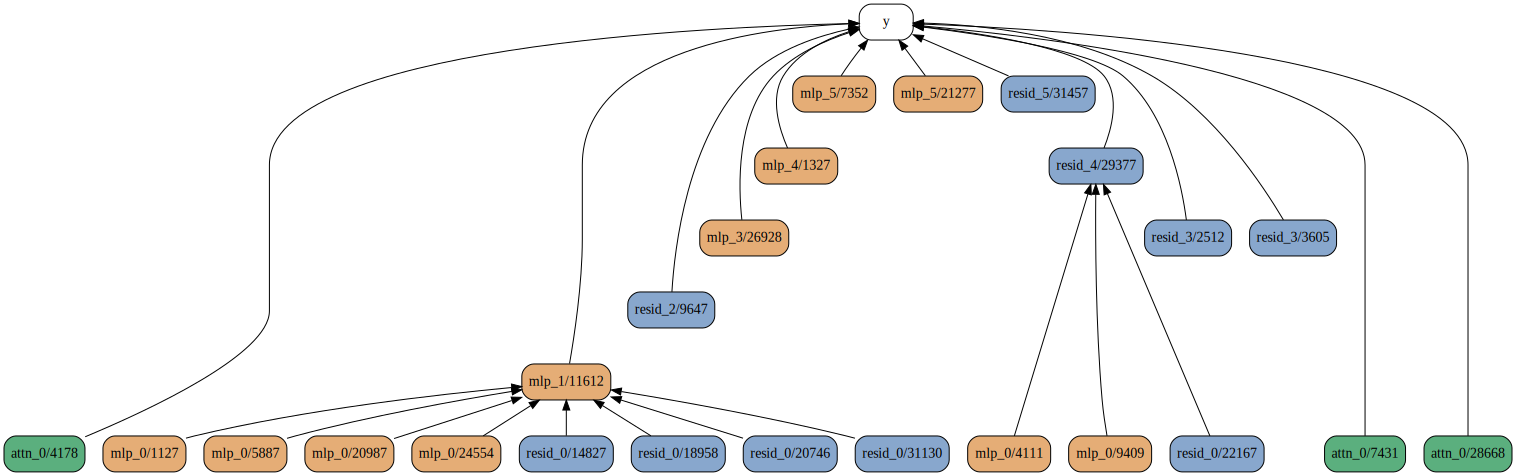

In [117]:
# initialize graph
G = Digraph(name="Feature Circuit")
G.graph_attr.update(rankdir='BT', newrank='true')
G.node_attr.update(shape="box", style="rounded")

circuit_path = "../simple_circuit.pkl"
circuit_figure_filename = os.path.basename(circuit_path).split(".pkl")[0]
circuit_figure_path = os.path.join("../figures/circuits", circuit_figure_filename)

# load dictionary
with open(circuit_path, "rb") as circuit_pickle:
    circuit = pickle.load(circuit_pickle)


# G.graph['node'] = {'shape': 'box', 'style': 'rounded'}
# G.graph['graph'] = {'rankdir': 'BT', 'compound': 'true'}
textcolor = "black"     # easy to change in case we use colors where white text will look better

nodes_by_layer = defaultdict(list)
edges = defaultdict(list)
nodeset = set()

for parent in circuit:
    if parent not in nodeset:
        if "mlp" in parent:
            nodecolor = "#e5ad76"   # camel
        elif "attn" in parent:
            nodecolor = "#5baf7e"   # kelly green
        elif "resid" in parent:
            nodecolor = "#88a7cd"   # pastel steel blue
        else:
            nodecolor = "white"

        if parent != "y":
            layer, feat_idx, component = parent.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            rank = int(layer) + 2
        else:
            nodename = "y"
            layer = 60
        layer = int(layer)
        nodes_by_layer[layer].append((parent, nodename, nodecolor, layer, feat_idx, component))
        nodeset.add(parent)
        # G.add_node(parent, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
        #            rank=rank)
    for child in circuit[parent]:
        child_name, child_effect = child
        if child_name not in nodeset:
            if "mlp" in child_name:
                nodecolor = "#e5ad76"
            elif "attn" in child_name:
                nodecolor = "#5baf7e"
            elif "resid" in child_name:
                nodecolor = "#88a7cd"
            else:
                nodecolor = "white"
            
            layer, feat_idx, component = child_name.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            layer = int(layer)
            nodes_by_layer[layer].append((child_name, nodename, nodecolor, layer, feat_idx, component))
        edges[child_name].append(parent)
        nodeset.add(child_name)
        #     G.add_node(child_name, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
        #                rank=rank)
        # G.add_edge(child_name, parent)

# subgraphs = []
first_node_per_layer = []
for layer in sorted(nodes_by_layer, reverse=True):
    with G.subgraph(name=f"layer {layer}") as subgraph:
        subgraph.attr(rank='same')
        for idx, node in enumerate(nodes_by_layer[layer]):
            if idx == 0:
                first_node_per_layer.append(node[0])
            subgraph.node(node[0], label=node[1], style="rounded,filled", fillcolor=node[2])
        # print(subgraph)
    # subgraphs.append(subgraph)

for child_node in edges:
    for parent_node in edges[child_node]:
        G.edge(child_node, parent_node)

# add invisible edges to make layer-based ranking work
for idx in range(len(first_node_per_layer)-1):
    G.edge(first_node_per_layer[idx+1], first_node_per_layer[idx], style="invis")


# for subgraph in subgraphs:
#     # print(subgraph)
#     G.add_subgraph(subgraph)

# G.layout('dot')
# print(G)
G.render(circuit_figure_path, format="png")
G

# A = to_agraph(G)
# A.layout('dot')
# print(A)